# Additional figures

The notebooks contains additional figures used in responses to reviewers. 

In [1]:
import xarray as xr
import numpy as np
from xgcm import Grid
import regionmask
from xmip.preprocessing import combined_preprocessing
from xmip.regionmask import merged_mask
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)

In [2]:
def plot_globe(ax, da, vmin=-999, vmax=999, vstep=1, lat_lon_ext = [-180, 180, -85., 85.],
               lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap,
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    cb = plt.colorbar(p, ax=ax, format='%.1e', extend='both', shrink=0.8)
    cb.ax.tick_params(labelsize=12)
    
    #ax.coastlines()
    
    #ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    #ax.add_feature(cfeature.LAND, facecolor='grey')
    #ax.add_feature(cfeature.COASTLINE)
    
    _ = plt.title(title, fontsize=14)
    return fig

## Remap contribution to vorticity budget

GFDL-MOM6 uses ALE-langragian method which solves the primitive equations on hybrid z*-sigma coordinates. The model needs to continuously remap data from sigma layers to depth levels and there is not diagnostic for the remapping term, which is related to $wdu/dz$. We compute this remapping term as a residual from the rest of the momentum budget diagnostics. 

The contribution from this remapping term to the barotropic vorticity bduget is quantified below.

In [13]:
# Read depth-integrated momentum diagnostics data

ds = xr.open_dataset("../../Data/OM4p25_JRA55_Momentum_Budget_1958_2017_Mean.nc")

print(ds)

<xarray.Dataset>
Dimensions:             (xq: 1440, yh: 1080, nv: 2, xh: 1440, yq: 1080)
Coordinates:
  * xq                  (xq) float64 -299.6 -299.3 -299.1 ... 59.66 59.91 60.16
  * yh                  (yh) float64 -80.39 -80.31 -80.23 ... 89.73 89.84 89.95
  * nv                  (nv) float64 1.0 2.0
  * xh                  (xh) float64 -299.7 -299.5 -299.2 ... 59.53 59.78 60.03
  * yq                  (yq) float64 -80.35 -80.27 -80.19 ... 89.78 89.89 90.0
Data variables: (12/67)
    hf_dudt_2d          (yh, xq) float64 ...
    hf_dvdt_2d          (yq, xh) float64 ...
    ubt_dt              (yh, xq) float64 ...
    vbt_dt              (yq, xh) float64 ...
    hf_PFu_2d           (yh, xq) float64 ...
    hf_PFv_2d           (yq, xh) float64 ...
    ...                  ...
    hfgeou              (yh, xh) float32 ...
    sftof               (yh, xh) float32 ...
    wet                 (yh, xh) float32 ...
    wet_c               (yq, xq) float32 ...
    wet_u               (yh, xq

In [10]:
# Create grid and interpolate depth, beta

OMEGA = 7.2921e-5
RAD_EARTH = 6.378e6

grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

depth_u = grid.interp(ds['deptho'] * ds['areacello'], 'X',  boundary='fill')  / ds['areacello_cu']
depth_v = grid.interp(ds['deptho'] * ds['areacello'], 'Y',  boundary='fill') / ds['areacello_cv']
depth_q = grid.interp(depth_u * ds['areacello_cu'], 'Y',  boundary='fill') / ds['areacello_bu']

colh_u = grid.interp(ds['col_height'] * ds['areacello'], 'X',  boundary='fill') / ds['areacello_cu']
colh_v = grid.interp(ds['col_height'] * ds['areacello'], 'Y',  boundary='fill') / ds['areacello_cv']

beta_v = 2*OMEGA*np.cos(ds.geolat_v * np.pi /180.)/RAD_EARTH
beta_q = 2*OMEGA*np.cos(ds.geolat_c * np.pi /180.)/RAD_EARTH

In [11]:
# compute terms in vorticity budget

rho_0 = 1035.

BPT = xr.Dataset()

Curl_Hrv2 = ( - grid.diff((ds['intz_rvxv_2d'] + ds['intz_gKEu_2d']) * ds.dxCu, 'Y', boundary='fill')
           + grid.diff((ds['intz_rvxu_2d'] + ds['intz_gKEv_2d']) * ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu
BPT['Curl_NL'] = Curl_Hrv2

tmpx = (ds['hf_dudt_2d'] * colh_u - ds['intz_CAu_2d']-ds['intz_PFu_2d']-ds['intz_diffu_2d']-
       ds['intz_u_BT_accel_2d'] - ds['taux']/rho_0 + ds['taux_bot']/rho_0)
tmpy = (ds['hf_dvdt_2d'] * colh_v - ds['intz_CAv_2d']-ds['intz_PFv_2d']-ds['intz_diffv_2d']-
       ds['intz_v_BT_accel_2d'] - ds['tauy'] /rho_0 + ds['tauy_bot']/rho_0)
Curl_remap = ( - grid.diff(tmpx * ds.dxCu, 'Y', boundary='fill')
             + grid.diff(tmpy * ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu
BPT['Curl_remap'] = Curl_remap

In [18]:
BPT = BPT.assign_coords({'geolon': ds['geolon'], 'geolat': ds['geolat'],
                      'geolon_u': ds['geolon_u'], 'geolat_u': ds['geolat_u'],
                      'geolon_v': ds['geolon_v'], 'geolat_v': ds['geolat_v'],
                      'geolon_c': ds['geolon_c'], 'geolat_c': ds['geolat_c']})

ds = ds.assign_coords({'geolon': ds['geolon'], 'geolat': ds['geolat'],
                      'geolon_u': ds['geolon_u'], 'geolat_u': ds['geolat_u'],
                      'geolon_v': ds['geolon_v'], 'geolat_v': ds['geolat_v'],
                      'geolon_c': ds['geolon_c'], 'geolat_c': ds['geolat_c']})

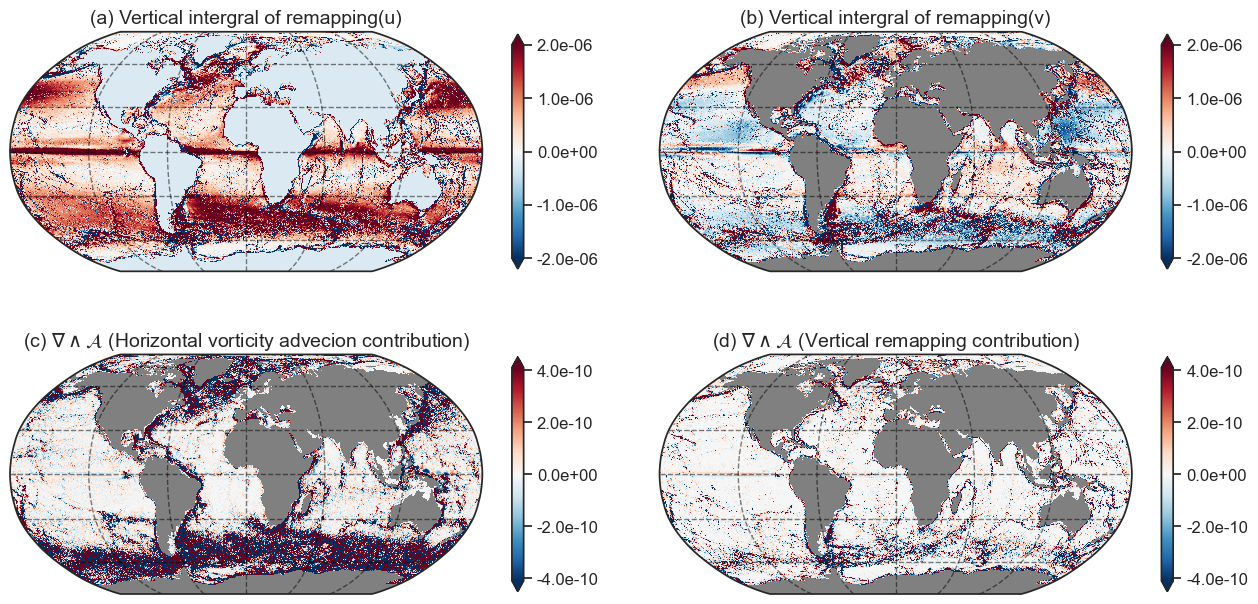

In [35]:
max_r = 0.2e-2

grid = plt.GridSpec(2, 2, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[16,8])

tmpx = (ds['hf_dudt_2d'] * colh_u - ds['intz_CAu_2d']-ds['intz_PFu_2d']-ds['intz_diffu_2d']-
       ds['intz_u_BT_accel_2d'] - ds['taux']/rho_0 + ds['taux_bot']/rho_0)
tmp = tmp.where(ds['wet_u']>0.1)
ax = fig.add_subplot(grid[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_globe(ax, tmpx, vmin=-1e-3*max_r, vmax=1e-3*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='(a) Vertical intergral of remapping(u)')

tmpy = (ds['hf_dvdt_2d'] * colh_v - ds['intz_CAv_2d']-ds['intz_PFv_2d']-ds['intz_diffv_2d']-
       ds['intz_v_BT_accel_2d'] - ds['tauy'] /rho_0 + ds['tauy_bot']/rho_0)
ax = fig.add_subplot(grid[0, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_globe(ax, tmpy, vmin=-1e-3*max_r, vmax=1e-3*max_r, vstep=2.e-3*max_r,
                   lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='(b) Vertical intergral of remapping(v)')

max_r = 4.1e-10
ax = fig.add_subplot(grid[1, 0], projection=ccrs.Robinson(),facecolor='grey')
tmp = BPT['Curl_NL']
_ = plot_globe(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lon='geolon_c', 
                   lat='geolat_c', cmap='RdBu_r', title=r'(c) $\nabla \wedge \mathcal{A}$ (Horizontal vorticity advecion contribution)')

max_r = 4.1e-10
ax = fig.add_subplot(grid[1, 1], projection=ccrs.Robinson(),facecolor='grey')
tmp = BPT['Curl_remap']
_ = plot_globe(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lon='geolon_c', 
                   lat='geolat_c', cmap='RdBu_r', title=r'(d) $\nabla \wedge \mathcal{A}$ (Vertical remapping contribution)')

fig.savefig('../../Plots/JAMES_Revision/Remap_contribution.png',dpi=300,bbox_inches='tight');